In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [96]:
#take the dataframe and only present the relevant category
def filter_aggregate_sales(frame, column_to_filter, column_value_to_filter, column_to_aggregate):
    frame = frame[frame[column_to_filter] == column_value_to_filter]
    frame = frame.groupby(column_to_aggregate).sum().T
    return frame

In [97]:
#ETSmodel prediction feature
def ETS_predict(frame, column_to_predict, days_to_predict):
    modelETS = ETSModel(frame.set_index('date')[column_to_predict].iloc[:-days_to_predict]/100, error="add", trend="add", seasonal="add",
                damped_trend=False, seasonal_periods=7)
    fit = modelETS.fit()
    prediction = fit.predict(start= frame.date.min(), end= frame.date.max())
    frame = frame.assign(ETS=prediction.values*100).set_index('date')
    return frame

In [98]:
#Create training/test dataset
def train_test_set(frame, target_feature, start_date, end_date):
    splittedframe = frame[start_date:end_date]
    input_train = splittedframe.drop(target_feature, axis='columns')
    target_train = splittedframe[target_feature]
    return input_train, target_train 

In [99]:
#Model and predict data using Random Forest 
def forest(X_train, y_train, X_test):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return y_predicted 

In [100]:
#Function to create train/test split and do model and prediction
def split_n_model(frame, target_feature, train_start_date, train_end_date,
                 test_start_date, test_end_date):
    
    X_train, y_train = train_test_set(frame=frame, target_feature = target_feature,
                                      start_date=train_start_date, end_date=train_end_date)
    
    X_test, y_test   = train_test_set(frame=frame, target_feature = target_feature,
                                      start_date=test_start_date, end_date=test_end_date)
    
    y_predicted      = forest(X_train, y_train, X_test)
    
    return y_test, y_predicted

### Fitting each category individually (without hierarchy):

In [101]:
#Cal_features is the features taken from 003-EK-model from cleanmergedframe
sales = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv')
cal_features = pd.read_csv('/Users/user/hts-forecast/volume/data/processed/sales_cal_features.csv')
cal_features.drop('Unnamed: 0', axis='columns', inplace=True)


In [102]:
food = filter_aggregate_sales(frame=sales, column_to_filter='cat_id',
                                    column_value_to_filter='FOODS', column_to_aggregate='cat_id')

list_of_foods = ['FOODS_1', 'FOODS_2', 'FOODS_3']

for foods in list_of_foods:
    food[foods] = filter_aggregate_sales(frame=sales, column_to_filter='dept_id',
                                    column_value_to_filter=foods, column_to_aggregate='dept_id')[foods]
    

food

cat_id,FOODS,FOODS_1,FOODS_2,FOODS_3
d_1,23178,2343,4094,16741
d_2,22758,2216,4209,16333
d_3,17174,1657,3174,12343
d_4,18878,1508,3606,13764
d_5,14603,1209,2869,10525
...,...,...,...,...
d_1937,24790,3073,4648,17069
d_1938,24737,3251,4551,16935
d_1939,28136,3735,4815,19586
d_1940,33599,4195,5940,23464


In [105]:
#Create features for foods category and sub categories
foods_sales = cal_features.copy()
foods_sales['FOODS'] = food['FOODS'].values
foods_sales['ETS'] = ETS_predict(frame=foods_sales, column_to_predict='FOODS', days_to_predict=120)['ETS'].values
foods_sales.date = pd.to_datetime(foods_sales.date)
foods_sales.set_index('date', inplace=True)

foods_1_sales = cal_features.copy()
foods_1_sales['FOODS_1'] = food['FOODS_1'].values
foods_1_sales['ETS'] = ETS_predict(frame=foods_1_sales, column_to_predict='FOODS_1', days_to_predict=120)['ETS'].values
foods_1_sales.date = pd.to_datetime(foods_1_sales.date)
foods_1_sales.set_index('date', inplace=True)

foods_2_sales = cal_features.copy()
foods_2_sales['FOODS_2'] = food['FOODS_2'].values
foods_2_sales['ETS'] = ETS_predict(frame=foods_2_sales, column_to_predict='FOODS_2', days_to_predict=120)['ETS'].values
foods_2_sales.date = pd.to_datetime(foods_2_sales.date)
foods_2_sales.set_index('date', inplace=True)

foods_3_sales = cal_features.copy()
foods_3_sales['FOODS_3'] = food['FOODS_3'].values
foods_3_sales['ETS'] = ETS_predict(frame=foods_3_sales, column_to_predict='FOODS_3', days_to_predict=120)['ETS'].values
foods_3_sales.date = pd.to_datetime(foods_3_sales.date)
foods_3_sales.set_index('date', inplace=True)


In [110]:
foods_y_test, foods_y_predicted = split_n_model(frame=foods_sales, target_feature='FOODS',
                                                train_start_date='2011-01-29', train_end_date='2016-01-22', 
                                                test_start_date='2016-01-24', test_end_date='2016-05-22')

foods_1_y_test, foods_1_y_predicted = split_n_model(frame=foods_1_sales, target_feature='FOODS_1',
                                                    train_start_date='2011-01-29', train_end_date='2016-01-22', 
                                                    test_start_date='2016-01-24', test_end_date='2016-05-22')

foods_2_y_test, foods_2_y_predicted = split_n_model(frame=foods_2_sales, target_feature='FOODS_2',
                                                    train_start_date='2011-01-29', train_end_date='2016-01-22', 
                                                  test_start_date='2016-01-24', test_end_date='2016-05-22')

foods_3_y_test, foods_3_y_predicted = split_n_model(frame=foods_3_sales, target_feature='FOODS_3',
                                                    train_start_date='2011-01-29', train_end_date='2016-01-22', 
                                                  test_start_date='2016-01-24', test_end_date='2016-05-22')


FOODS:
Average sales for foods items is:  28314.183333333334
Root mean squared error is:  4170.454100974297
Residual mean is:  3104.758333333333


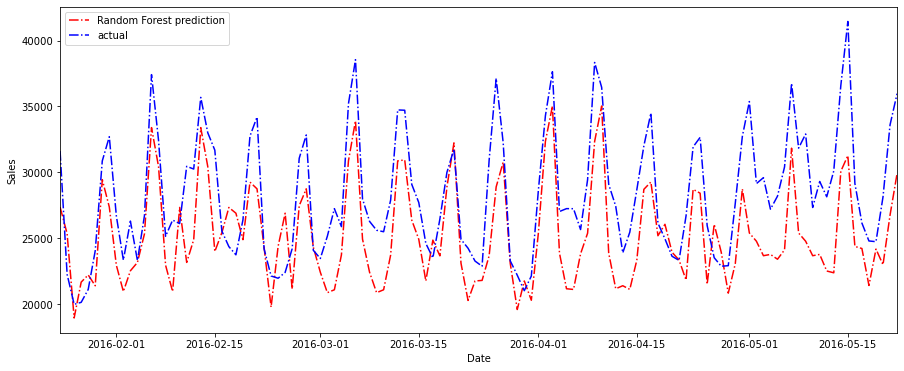

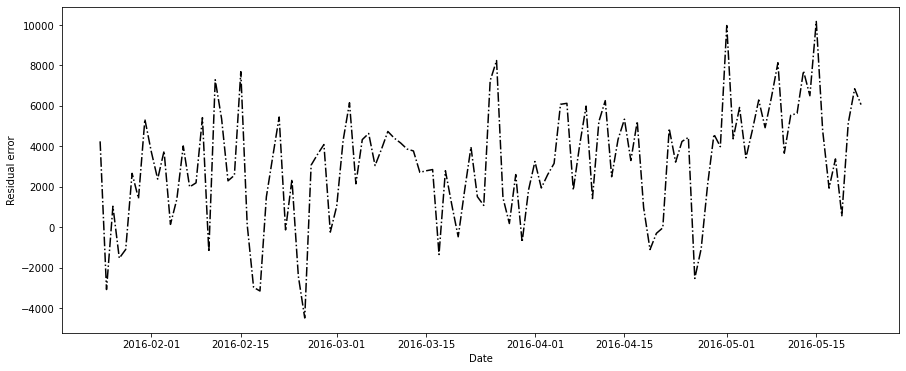

FOODS_1:
Average sales for foods(1) items is:  3216.4416666666666
Root mean squared error is:  865.9628215652987
Residual mean is:  -235.24166666666667


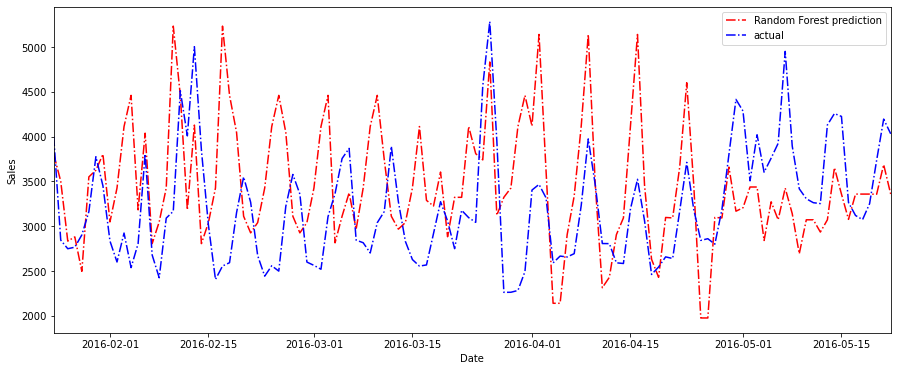

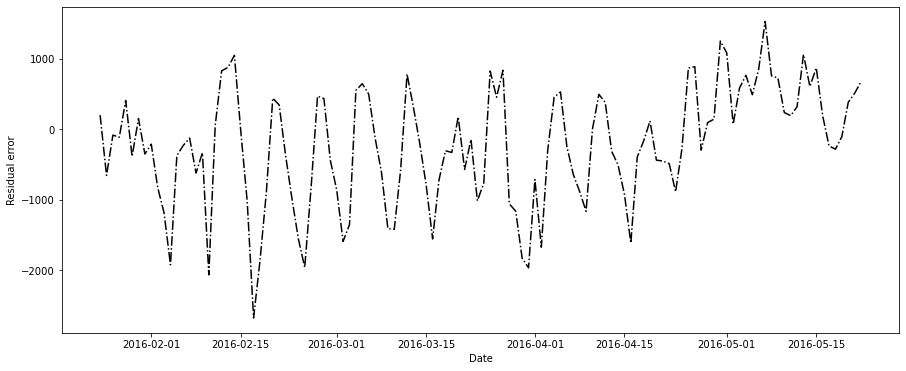

FOODS_2:
Average sales for foods(2) items is:  5733.533333333334
Root mean squared error is:  1325.3212723713448
Residual mean is:  968.275


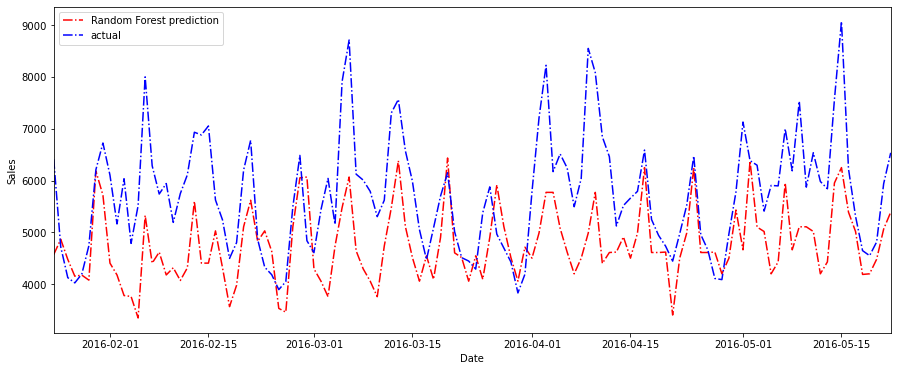

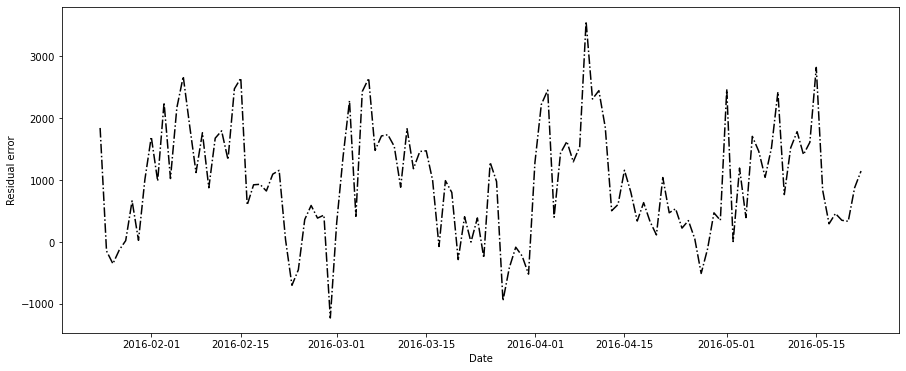

FOODS_3:
Average sales for foods(3) items is:  19364.208333333332
Root mean squared error is:  2591.3878520977905
Residual mean is:  2012.6


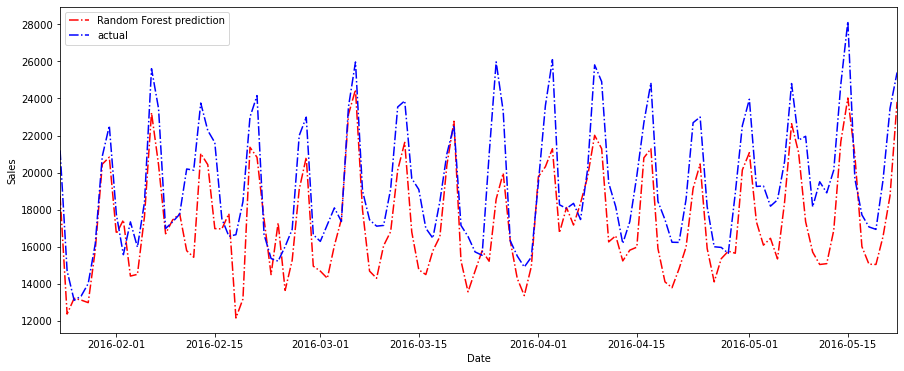

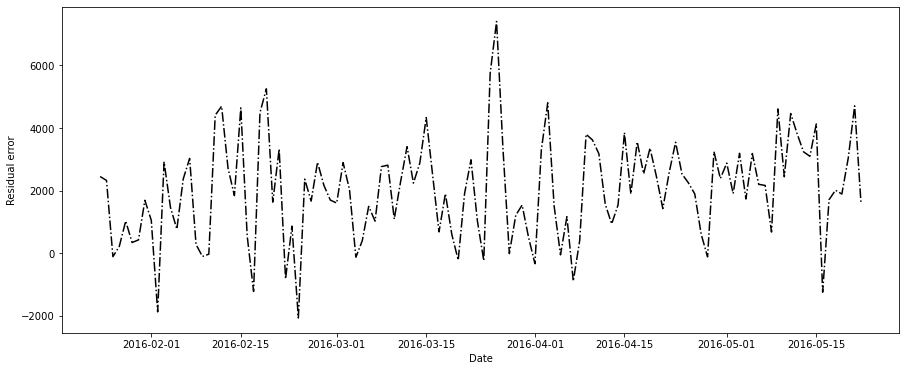

In [116]:
print("FOODS:")
print("Average sales for foods items is: ", foods_y_test.mean())
rmse = sqrt(mean_squared_error(foods_y_test, foods_y_predicted))
print("Root mean squared error is: ", rmse)
    
plt.figure(figsize=(15,6))
plt.plot(foods_y_test.index, foods_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_y_test-foods_y_predicted
print("Residual mean is: ", y_residual.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()

print("FOODS_1:")
print("Average sales for foods(1) items is: ", foods_1_y_test.mean())
rmse = sqrt(mean_squared_error(foods_1_y_test, foods_1_y_predicted))
print("Root mean squared error is: ", rmse)
    
plt.figure(figsize=(15,6))
plt.plot(foods_1_y_test.index, foods_1_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_1_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_1_y_test-foods_1_y_predicted
print("Residual mean is: ", y_residual.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()

print("FOODS_2:")
print("Average sales for foods(2) items is: ", foods_2_y_test.mean())
rmse = sqrt(mean_squared_error(foods_2_y_test, foods_2_y_predicted))
print("Root mean squared error is: ", rmse)
    
plt.figure(figsize=(15,6))
plt.plot(foods_2_y_test.index, foods_2_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_2_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_2_y_test-foods_2_y_predicted
print("Residual mean is: ", y_residual.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()

print("FOODS_3:")
print("Average sales for foods(3) items is: ", foods_3_y_test.mean())
rmse = sqrt(mean_squared_error(foods_3_y_test, foods_3_y_predicted))
print("Root mean squared error is: ", rmse)
    
plt.figure(figsize=(15,6))
plt.plot(foods_3_y_test.index, foods_3_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_3_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_3_y_test-foods_3_y_predicted
print("Residual mean is: ", y_residual.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()
